In [9]:
import pandas as pd
import numpy as np
import subprocess
import seaborn as sns
import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob

def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [4]:
%%bash
source ~/.bashrc
conda activate bcftools_call
bcftools query -l ../calls/apal_imputation_panel.vcf.gz | wc -l

176


In [2]:
hifimetadata = pd.read_csv("../hifi_metadata.csv")
metadata = pd.read_csv("../filtered_DARPA_metadata.csv")
platemap = pd.read_csv("../huck_sub_id.csv")
metadata = platemap.merge(metadata, how = "left", on = "Huck_Sub_ID")
metadata["Novogene_ID"] = "A" + metadata["Database ID"].astype(str)

We filter for GQ>10. A lot of the times we filter for GQ>10 but we're running WhatsHap which can fix incorrect genotypes based on phasing information, so we can be a bit more lenient here. We also remove sites with very low and very high mean depth:

In [26]:
%%bash
source ~/.bashrc
conda activate ipyrad
vcftools --gzvcf ../calls/apal_imputation_panel.vcf.gz \
    --site-mean-depth

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ../calls/apal_imputation_panel.vcf.gz
	--site-mean-depth

Using zlib version: 1.2.11
After filtering, kept 176 out of 176 Individuals
Outputting Depth for Each Site
After filtering, kept 9737242 out of a possible 9737242 Sites
Run Time = 749.00 seconds


In [3]:
meandepth = pd.read_csv("./out.ldepth.mean", sep = "\t")

/tmp/ipykernel_843396/2483726510.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(meandepth["MEAN_DEPTH"])


<Axes: xlabel='MEAN_DEPTH', ylabel='Density'>

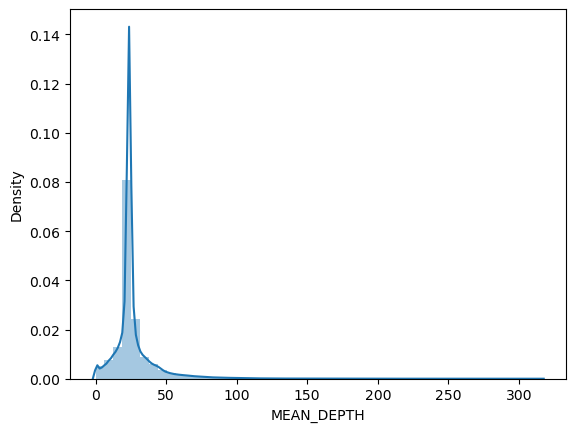

In [32]:
sns.distplot(meandepth["MEAN_DEPTH"])

In [33]:
%%bash
source ~/.bashrc
conda activate bcftools_call
bcftools +tag2tag ../calls/apal_imputation_panel.vcf.gz -- --pl-to-gl \
    | bcftools view -i 'FORMAT/GQ>10' \
    | bcftools view -i 'QUAL>10 & F_MISSING<0.05 & MEAN(FMT/DP)>5 & MEAN(FMT/DP)<53' \
    -O b > ../calls/apal_imputation_panel_filtered.bcf
bcftools index ../calls/apal_imputation_panel_filtered.bcf
bcftools view ../calls/apal_imputation_panel_filtered.bcf | grep -v "^#" | wc -l

8081396


The fastest way to run WhatsHap in the quickest, most memory-efficient way is to split the VCF by individual and phase with the associated BAM file, so that's what we'll do here:

In [5]:
!cat ../whatshap.sh

#!/bin/bash
#SBATCH --nodes=1
#SBATCH --time=48:00:00
#SBATCH --job-name=whatshap
#SBATCH --account=open

source ~/.bashrc
conda activate pacbiotools

INFILE=$1
OUTPATH=$2
BAMPATH=$3
PREFIX=$4

cd $SLURM_SUBMIT_DIR
mkdir -p ${OUTPATH}

bcftools view ${INFILE} \
    -s ${PREFIX} -O b \
    > ${OUTPATH}/${PREFIX}.bcf

bcftools index ${OUTPATH}/${PREFIX}.bcf

whatshap phase -o ${OUTPATH}/${PREFIX}_phased.vcf \
    --reference ../references/apal_and_sym.fa \
    --indels --include-homozygous --distrust-genotypes \
    --changed-genotype-list ${OUTPATH}/${PREFIX}_corrected_genos.txt \
    ${OUTPATH}/${PREFIX}.bcf \
    ${BAMPATH}/${PREFIX}.markdup.bam


In [7]:
%%bash
source ~/.bashrc
conda activate bcftools_call
bcftools query -l ../calls/apal_imputation_panel.vcf.gz > ../illumina_sample_list.txt

In [3]:
samplelist = pd.read_csv("../illumina_sample_list.txt", header = None, names = ["Sample"])

In [7]:
samps = samplelist["Sample"][~samplelist["Sample"].isin(["A22249", "A22089", "A22103", "A22152"])].tolist()
for i in samps:
    task = "whatshap"
    mem = "32"
    cpus = "2"
    infile = '../calls/apal_imputation_panel_filtered.bcf'
    outpath = "/storage/home/nsl5160/scratch/darpa/whatshap"
    bampath = "/storage/home/nsl5160/scratch/darpa/mapped"
    prefix = str(i)
    bamprefix = str(i)
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         infile + " " + outpath + " " + bampath + " " + prefix + " " + bamprefix ], shell=True)

Submitted batch job 7320420
Submitted batch job 7320421
Submitted batch job 7320422
Submitted batch job 7320423
Submitted batch job 7320424
Submitted batch job 7320425
Submitted batch job 7320426
Submitted batch job 7320427
Submitted batch job 7320428
Submitted batch job 7320429
Submitted batch job 7320430
Submitted batch job 7320431
Submitted batch job 7320432
Submitted batch job 7320433
Submitted batch job 7320434
Submitted batch job 7320435
Submitted batch job 7320436
Submitted batch job 7320437
Submitted batch job 7320438
Submitted batch job 7320439
Submitted batch job 7320440
Submitted batch job 7320441
Submitted batch job 7320442
Submitted batch job 7320443
Submitted batch job 7320444
Submitted batch job 7320445
Submitted batch job 7320446
Submitted batch job 7320447
Submitted batch job 7320448
Submitted batch job 7320449
Submitted batch job 7320450
Submitted batch job 7320451
Submitted batch job 7320452
Submitted batch job 7320453
Submitted batch job 7320454
Submitted batch job 

In [4]:
longreads = {"A22249": "20155", 
             "A22089": "20156", 
             "A22103": "20148", 
             "A22152": "20153"}

In [6]:
samps = list(longreads.keys())
for i in samps:
    task = "addreplacerg"
    mem = "16"
    cpus = "2"
    filepath = "/storage/home/nsl5160/scratch/darpa/mapped"
    fileprefix = str(longreads[i])
    newrg = str(i)
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         filepath + " " + fileprefix + " " + newrg ], shell=True)

sbatch: slurm_job_submit: No account set, using default acct: open


Submitted batch job 7364119


sbatch: slurm_job_submit: No account set, using default acct: open


Submitted batch job 7364120


sbatch: slurm_job_submit: No account set, using default acct: open


Submitted batch job 7364121
Submitted batch job 7364122


sbatch: slurm_job_submit: No account set, using default acct: open


In [7]:
samps = list(longreads.keys())
for i in samps:
    task = "whatshap"
    mem = "16"
    cpus = "2"
    infile = '../calls/apal_imputation_panel_filtered.bcf'
    outpath = "/storage/home/nsl5160/scratch/darpa/whatshap"
    bampath = "/storage/home/nsl5160/scratch/darpa/mapped"
    prefix = str(i)
    bamprefix = str(longreads[i])
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         infile + " " + outpath + " " + bampath + " " + prefix + " " + bamprefix ], shell=True)

Submitted batch job 7365496
Submitted batch job 7365497
Submitted batch job 7365498
Submitted batch job 7365499


To merge all the samples back together, they need to be gzipped and indexed, so we'll do that here quickly in a loop:

In [2]:
directory = "/storage/home/nsl5160/scratch/darpa/whatshap/"
files = glob.glob(directory + "*_phased.vcf")
for file in files:
    task = "compress_vcf"
    mem = "16"
    cpus = "2"
    infile = file
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         infile], shell=True)

Submitted batch job 7807286
Submitted batch job 7807287
Submitted batch job 7807288
Submitted batch job 7807289
Submitted batch job 7807290
Submitted batch job 7807291
Submitted batch job 7807292
Submitted batch job 7807293
Submitted batch job 7807294
Submitted batch job 7807295
Submitted batch job 7807296
Submitted batch job 7807297
Submitted batch job 7807298
Submitted batch job 7807299
Submitted batch job 7807300
Submitted batch job 7807301
Submitted batch job 7807302
Submitted batch job 7807303
Submitted batch job 7807304
Submitted batch job 7807305
Submitted batch job 7807306
Submitted batch job 7807307
Submitted batch job 7807308
Submitted batch job 7807309
Submitted batch job 7807310
Submitted batch job 7807311
Submitted batch job 7807312
Submitted batch job 7807313
Submitted batch job 7807314
Submitted batch job 7807315
Submitted batch job 7807316
Submitted batch job 7807317
Submitted batch job 7807318
Submitted batch job 7807319
Submitted batch job 7807320
Submitted batch job 

And then join them:

In [44]:
nonclonal = pd.read_csv("/storage/home/nsl5160/scratch/kin_sr_only_wgs_0.3536.king.cutoff.in.id")
nonclonal = nonclonal[~nonclonal["#IID"].str.contains("storage")].reset_index(drop=True)
nonclonal = nonclonal[nonclonal["#IID"] != "A131"].reset_index(drop=True) # this sample was a pool of individuals so we actually need to drop it

In [45]:
unrelated = pd.read_csv("/storage/home/nsl5160/scratch/kin_sr_only_wgs_0.0884.king.cutoff.in.id")
unrelated = unrelated[~unrelated["#IID"].str.contains("storage")].reset_index(drop=True)

In [46]:
joiner = " "
nonclonal = joiner.join(("/storage/home/nsl5160/scratch/darpa/whatshap/" + nonclonal["#IID"] + "_phased.vcf.gz").tolist())

In [47]:
joiner = " "
unrelated = joiner.join(("/storage/home/nsl5160/scratch/darpa/whatshap/" + unrelated["#IID"] + "_phased.vcf.gz").tolist())

We'll generate two datasets - one for the reference panel (unrelated):

In [48]:
directory = "/storage/home/nsl5160/scratch/darpa/whatshap/"
outfile = "../calls/apal_imputation_panel_nonclonal_illumina_filtered_whatshap.vcf.gz"
print(["source ~/.bashrc ; conda activate ipyrad ; bcftools merge --threads 20 " + 
       nonclonal + " -O z > " + outfile + " ; tabix " + outfile ])

['source ~/.bashrc ; conda activate ipyrad ; bcftools merge --threads 20 /storage/home/nsl5160/scratch/darpa/whatshap/A22007_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22036_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22037_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22042_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22048_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22051_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22054_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22055_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22064_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22065_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22066_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22067_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22068_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22069_phased.vcf.gz /st

And one for the GWAS, which can have some relatedness, as this will be taken into account in the LMM:

In [49]:
directory = "/storage/home/nsl5160/scratch/darpa/whatshap/"
outfile = "../calls/apal_imputation_panel_unrelated_illumina_filtered_whatshap.vcf.gz"
print(["source ~/.bashrc ; conda activate ipyrad ; bcftools merge --threads 20 " + 
       unrelated + " -O z > " + outfile + " ; tabix " + outfile ])

['source ~/.bashrc ; conda activate ipyrad ; bcftools merge --threads 20 /storage/home/nsl5160/scratch/darpa/whatshap/A22036_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22037_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22042_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22048_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22054_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22055_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22064_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22065_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22066_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22067_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22068_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22073_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22076_phased.vcf.gz /storage/home/nsl5160/scratch/darpa/whatshap/A22077_phased.vcf.gz /st

Prior to phasing, we need to filter the unrelated dataset by running it through Ruth (https://github.com/statgen/ruth) to remove sites that are out of HWE according to genotype likelihoods. We'll be able to use this same list of SNPs to filter the dataset with some relatedness as the HWE estimates should be most accurate in the unrelated dataset. First thing we need to do is remove repeat-associated, multiallelic, indel, and invariant sites as these will bias the PCA axes that we need to generate for the Ruth HWE analyses. We also thin the SNPs to 20kb windows with vcftools and then perform LD pruning with PLINK2 to eliminate the effect of linkage in our population analyses. Finally, we'll only include individuals in the reference panel that were >90% ancestry from one of the two Florida clusters. Admixed individuals will interfere with our ability to impute so we need to drop these samples:

In [69]:
%%bash
source ~/.bashrc
conda activate ipyrad
vcftools --gzvcf ../calls/apal_imputation_panel_unrelated_illumina_filtered_whatshap.vcf.gz \
    --mac 3 --max-alleles 2 --min-alleles 2 --remove-indels \
    --thin 20000 --recode --out ~/scratch/HWE_thinned

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ../calls/apal_imputation_panel_unrelated_illumina_filtered_whatshap.vcf.gz
	--mac 3
	--max-alleles 2
	--min-alleles 2
	--thin 20000
	--out /storage/home/nsl5160/scratch/HWE_thinned
	--recode
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 128 out of 128 Individuals
Outputting VCF file...
After filtering, kept 14320 out of a possible 8081396 Sites
Run Time = 428.00 seconds


In [70]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools annotate --set-id +'%CHROM\_%POS\_%REF\_%FIRST_ALT' ~/scratch/HWE_thinned.recode.vcf \
    -Ov > ~/scratch/HWE.vcf

In [5]:
%%bash
source ~/.bashrc
conda activate ipyrad
plink2 --vcf ~/scratch/HWE.vcf \
    --geno 0.1 --threads 8 --maf 0.01 \
    --indep-pairwise 500kb 0.2 --allow-extra-chr \
    --out ~/scratch/HWE_pca

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /storage/home/nsl5160/scratch/HWE_pca.log.
Options in effect:
  --allow-extra-chr
  --geno 0.1
  --indep-pairwise 500kb 0.2
  --maf 0.01
  --out /storage/home/nsl5160/scratch/HWE_pca
  --threads 8
  --vcf /storage/home/nsl5160/scratch/HWE.vcf

Start time: Tue Feb  6 14:42:23 2024
128802 MiB RAM detected; reserving 64401 MiB for main workspace.
Using up to 8 compute threads.
--vcf: 14320 variants scanned.
--vcf: /storage/home/nsl5160/scratch/HWE_pca-temporary.pgen +
/storage/home/nsl5160/scratch/HWE_pca-temporary.pvar +
/storage/home/nsl5160/scratch/HWE_pca-temporary.psam written.
128 samples (0 females, 0 males, 128 ambiguou

In [94]:
%%bash
source ~/.bashrc
conda activate ipyrad
plink2 --vcf ~/scratch/HWE.vcf \
    --extract /storage/home/nsl5160/scratch/HWE_pca.prune.in \
    --allow-extra-chr --maf 0.05 --geno 0.05 \
    --pca --out ~/scratch/HWE_pca

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /storage/home/nsl5160/scratch/HWE_pca.log.
Options in effect:
  --allow-extra-chr
  --extract /storage/home/nsl5160/scratch/HWE_pca.prune.in
  --geno 0.05
  --maf 0.05
  --out /storage/home/nsl5160/scratch/HWE_pca
  --pca
  --vcf /storage/home/nsl5160/scratch/HWE.vcf

Start time: Tue Feb  6 15:33:09 2024
128802 MiB RAM detected; reserving 64401 MiB for main workspace.
Using up to 24 threads (change this with --threads).
--vcf: 14320 variants scanned.
--vcf: /storage/home/nsl5160/scratch/HWE_pca-temporary.pgen +
/storage/home/nsl5160/scratch/HWE_pca-temporary.pvar +
/storage/home/nsl5160/scratch/HWE_pca-temporary.psam written

In [19]:
%%bash
source ~/.bashrc
conda activate ipyrad 
vcftools --vcf ~/scratch/HWE.vcf --snps /storage/home/nsl5160/scratch/HWE_pca.prune.in \
    --recode --out ~/scratch/HWE_pca

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf /storage/home/nsl5160/scratch/HWE.vcf
	--out /storage/home/nsl5160/scratch/HWE_pca
	--recode
	--snps /storage/home/nsl5160/scratch/HWE_pca.prune.in

After filtering, kept 128 out of 128 Individuals
Outputting VCF file...
After filtering, kept 11237 out of a possible 14320 Sites
Run Time = 7.00 seconds


In [20]:
%%bash
source ~/.bashrc
conda activate beagle
perl ../vcf2Beagle.pl --in=/scratch/nsl5160/HWE_pca.recode.vcf \
    --out=/scratch/nsl5160/HWE_thinned.beagle --PL
gzip /scratch/nsl5160/HWE_thinned.beagle

In [21]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools query -l /scratch/nsl5160/HWE_pca.recode.vcf > ~/scratch/refpanel_samplelist.txt

In [2]:
samples = pd.read_csv("~/scratch/refpanel_samplelist.txt", header = None, names = ["Novogene_ID"])

In [3]:
metadata = pd.read_csv("../2024_01_12_PsuData_fixed.csv")

In [4]:
samples = samples.merge(metadata[["Novogene_ID",  "region"]], how = "left", on = "Novogene_ID")

In [26]:
%%bash
source ~/.bashrc
conda activate angsd
for i in 1 2 3 4 5 6 7 8 9 10; do
    for rep in 1 2 3 4 5; do
        NGSadmix -likes /scratch/nsl5160/HWE_thinned.beagle.gz \
            -K ${i} -minMaf 0.01 \
            -seed ${rep} \
            -o ~/scratch/ngsadmix_k${i}_${rep} -P 10
    done
done

Input: lname=/scratch/nsl5160/HWE_thinned.beagle.gz nPop=1, fname=(null) qname=(null) outfiles=/storage/home/nsl5160/scratch/ngsadmix_k1_1
Setup: seed=1 nThreads=10 method=1
Convergence: maxIter=2000 tol=0.000010 tolLike50=0.100000 dymBound=0
Filters: misTol=0.050000 minMaf=0.010000 minLrt=0.000000 minInd=0
Input file has dim: nsites=11237 nind=128
Input file has dim (AFTER filtering): nsites=1360 nind=128
iter[start] like is=-555939.607432
EM accelerated Thread has reached convergence with tol 0.000010
best like=608742.106408 after 39 iterations
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k1_1.log
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k1_1.qopt
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k1_1.fopt.gz
	[ALL done] cpu-time used =  1.98 sec
	[ALL done] walltime used =  1.00 sec
Input: lname=/scratch/nsl5160/HWE_thinned.beagle.gz nPop=1, fname=(null) qname=(null) outfiles=/storage/home/nsl5160/scratch/ngsadmix_k1_2
Setup: seed=2 nThrea

Setup: seed=5 nThreads=10 method=1
Convergence: maxIter=2000 tol=0.000010 tolLike50=0.100000 dymBound=0
Filters: misTol=0.050000 minMaf=0.010000 minLrt=0.000000 minInd=0
Input file has dim: nsites=11237 nind=128
Input file has dim (AFTER filtering): nsites=1360 nind=128
iter[start] like is=-564395.876168
iter[50] like is=617863.417280 thres=0.000304
iter[100] like is=617869.240263 thres=0.000449
iter[150] like is=617873.901819 thres=0.000022
EM accelerated Thread has reached convergence with tol 0.000010
best like=617874.506259 after 182 iterations
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k2_5.log
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k2_5.qopt
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k2_5.fopt.gz
	[ALL done] cpu-time used =  8.10 sec
	[ALL done] walltime used =  3.00 sec
Input: lname=/scratch/nsl5160/HWE_thinned.beagle.gz nPop=3, fname=(null) qname=(null) outfiles=/storage/home/nsl5160/scratch/ngsadmix_k3_1
Setup: seed=1 nThr

	[ALL done] cpu-time used =  24.19 sec
	[ALL done] walltime used =  8.00 sec
Input: lname=/scratch/nsl5160/HWE_thinned.beagle.gz nPop=4, fname=(null) qname=(null) outfiles=/storage/home/nsl5160/scratch/ngsadmix_k4_3
Setup: seed=3 nThreads=10 method=1
Convergence: maxIter=2000 tol=0.000010 tolLike50=0.100000 dymBound=0
Filters: misTol=0.050000 minMaf=0.010000 minLrt=0.000000 minInd=0
Input file has dim: nsites=11237 nind=128
Input file has dim (AFTER filtering): nsites=1360 nind=128
iter[start] like is=-572974.310239
iter[50] like is=624550.446225 thres=0.016404
iter[100] like is=624755.120194 thres=0.006315
iter[150] like is=624802.360647 thres=0.000716
iter[200] like is=624822.166229 thres=0.002092
iter[250] like is=624838.396135 thres=0.002708
iter[300] like is=624841.157946 thres=0.000327
EM accelerated Thread has reached convergence with tol 0.000010
best like=624841.168601 after 319 iterations
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k4_3.log
	-> Dumpedfiles are

iter[300] like is=628095.314326 thres=0.000925
EM accelerated Thread has reached convergence with tol 0.000010
best like=628095.317231 after 312 iterations
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k5_4.log
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k5_4.qopt
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k5_4.fopt.gz
	[ALL done] cpu-time used =  24.21 sec
	[ALL done] walltime used =  7.00 sec
Input: lname=/scratch/nsl5160/HWE_thinned.beagle.gz nPop=5, fname=(null) qname=(null) outfiles=/storage/home/nsl5160/scratch/ngsadmix_k5_5
Setup: seed=5 nThreads=10 method=1
Convergence: maxIter=2000 tol=0.000010 tolLike50=0.100000 dymBound=0
Filters: misTol=0.050000 minMaf=0.010000 minLrt=0.000000 minInd=0
Input file has dim: nsites=11237 nind=128
Input file has dim (AFTER filtering): nsites=1360 nind=128
iter[start] like is=-574731.629103
iter[50] like is=627705.810017 thres=0.006801
iter[100] like is=627911.360920 thres=0.001786
iter[150] like is

Convergence achived because log likelihooditer difference for 50 iteraction is less than 0.100000
best like=629420.574893 after 950 iterations
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k6_5.log
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k6_5.qopt
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k6_5.fopt.gz
	[ALL done] cpu-time used =  82.92 sec
	[ALL done] walltime used =  24.00 sec
Input: lname=/scratch/nsl5160/HWE_thinned.beagle.gz nPop=7, fname=(null) qname=(null) outfiles=/storage/home/nsl5160/scratch/ngsadmix_k7_1
Setup: seed=1 nThreads=10 method=1
Convergence: maxIter=2000 tol=0.000010 tolLike50=0.100000 dymBound=0
Filters: misTol=0.050000 minMaf=0.010000 minLrt=0.000000 minInd=0
Input file has dim: nsites=11237 nind=128
Input file has dim (AFTER filtering): nsites=1360 nind=128
iter[start] like is=-576480.019669
iter[50] like is=631070.296695 thres=0.018506
iter[100] like is=631711.105194 thres=0.006120
iter[150] like is=631910.0545

Setup: seed=2 nThreads=10 method=1
Convergence: maxIter=2000 tol=0.000010 tolLike50=0.100000 dymBound=0
Filters: misTol=0.050000 minMaf=0.010000 minLrt=0.000000 minInd=0
Input file has dim: nsites=11237 nind=128
Input file has dim (AFTER filtering): nsites=1360 nind=128
iter[start] like is=-576921.758001
iter[50] like is=632960.811796 thres=0.007288
iter[100] like is=633275.133394 thres=0.004855
iter[150] like is=633370.514420 thres=0.001651
iter[200] like is=633411.458603 thres=0.001668
iter[250] like is=633462.480113 thres=0.001002
iter[300] like is=633476.500689 thres=0.002671
iter[350] like is=633504.219822 thres=0.001945
iter[400] like is=633511.091139 thres=0.001051
iter[450] like is=633552.251214 thres=0.001803
iter[500] like is=633559.208917 thres=0.000066
iter[550] like is=633568.902638 thres=0.000098
iter[600] like is=633572.393154 thres=0.000399
iter[650] like is=633576.578662 thres=0.000191
EM accelerated Thread has reached convergence with tol 0.000010
best like=633576.579

	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k9_2.qopt
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k9_2.fopt.gz
	[ALL done] cpu-time used =  64.94 sec
	[ALL done] walltime used =  18.00 sec
Input: lname=/scratch/nsl5160/HWE_thinned.beagle.gz nPop=9, fname=(null) qname=(null) outfiles=/storage/home/nsl5160/scratch/ngsadmix_k9_3
Setup: seed=3 nThreads=10 method=1
Convergence: maxIter=2000 tol=0.000010 tolLike50=0.100000 dymBound=0
Filters: misTol=0.050000 minMaf=0.010000 minLrt=0.000000 minInd=0
Input file has dim: nsites=11237 nind=128
Input file has dim (AFTER filtering): nsites=1360 nind=128
iter[start] like is=-578073.385422
iter[50] like is=633241.604659 thres=0.057767
iter[100] like is=634300.886399 thres=0.026729
iter[150] like is=634641.235346 thres=0.009904
iter[200] like is=634727.094595 thres=0.011852
iter[250] like is=634775.343569 thres=0.003261
iter[300] like is=634800.233098 thres=0.002237
iter[350] like is=634841.591162 thres=0.002579
iter[4

iter[300] like is=636748.944152 thres=0.005363
iter[350] like is=636809.814530 thres=0.018826
iter[400] like is=636858.551998 thres=0.000772
iter[450] like is=636867.461826 thres=0.000184
iter[500] like is=636874.284514 thres=0.009622
iter[550] like is=636881.263819 thres=0.000088
iter[600] like is=636880.958196 thres=0.005050
Convergence achived because log likelihooditer difference for 50 iteraction is less than 0.100000
best like=636880.958196 after 600 iterations
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k10_3.log
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k10_3.qopt
	-> Dumpedfiles are: /storage/home/nsl5160/scratch/ngsadmix_k10_3.fopt.gz
	[ALL done] cpu-time used =  80.75 sec
	[ALL done] walltime used =  22.00 sec
Input: lname=/scratch/nsl5160/HWE_thinned.beagle.gz nPop=10, fname=(null) qname=(null) outfiles=/storage/home/nsl5160/scratch/ngsadmix_k10_4
Setup: seed=4 nThreads=10 method=1
Convergence: maxIter=2000 tol=0.000010 tolLike50=0.100000 d

In [27]:
%%bash
rm ~/scratch/bestk.tab
for i in 1 2 3 4 5 6 7 8 9 10; do
    for rep in 1 2 3 4 5; do
        paste <( echo ${i} ) <( tail -1 /storage/home/nsl5160/scratch/ngsadmix_k${i}_${rep}.log \
            | cut -d" " -f2 | sed "s/like=//g" ) >> ~/scratch/bestk.tab
    done
done

<Axes: >

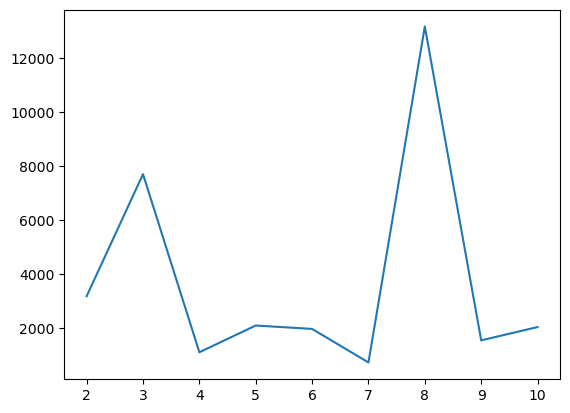

In [28]:
deltak = pd.read_csv("~/scratch/bestk.tab", sep = "\t", names = ["k", "loglike"])
deltak["loglike"] = deltak["loglike"].abs()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
deltak_val = []
for k in ks:
    deltak_val = deltak_val + [np.mean(deltak["loglike"][deltak["k"] == k])/np.std(deltak["loglike"][deltak["k"] == k])]
plt.figure()
sns.lineplot(x = ks, y = deltak_val)

In [6]:
struct = pd.concat([samples,struct], axis = 1)

In [7]:
struct = struct.round(5)

In [111]:
with open('../pure_florida.txt', 'w') as f:
    for line in (struct["Novogene_ID"][struct["region"] == "Florida"][struct[2] > 0.9].tolist() + 
struct["Novogene_ID"][struct["region"] == "Florida"][struct[1] > 0.9].tolist() + 
struct["Novogene_ID"][struct["region"] != "Florida"].tolist()):
        f.write(f"{line}\n")

In [113]:
%%bash
source ~/.bashrc
conda activate ipyrad
plink2 --vcf ~/scratch/HWE.vcf \
    --extract /storage/home/nsl5160/scratch/HWE_pca.prune.in \
    --keep ../pure_florida.txt --allow-extra-chr --maf 0.05 --geno 0.05 \
    --pca --out ~/scratch/HWE_pca_pure

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /storage/home/nsl5160/scratch/HWE_pca_pure.log.
Options in effect:
  --allow-extra-chr
  --extract /storage/home/nsl5160/scratch/HWE_pca.prune.in
  --geno 0.05
  --keep ../pure_florida.txt
  --maf 0.05
  --out /storage/home/nsl5160/scratch/HWE_pca_pure
  --pca
  --vcf /storage/home/nsl5160/scratch/HWE.vcf

Start time: Tue Feb  6 16:17:15 2024
128802 MiB RAM detected; reserving 64401 MiB for main workspace.
Using up to 24 threads (change this with --threads).
--vcf: 14320 variants scanned.
--vcf: /storage/home/nsl5160/scratch/HWE_pca_pure-temporary.pgen +
/storage/home/nsl5160/scratch/HWE_pca_pure-temporary.pvar +
/storage/ho

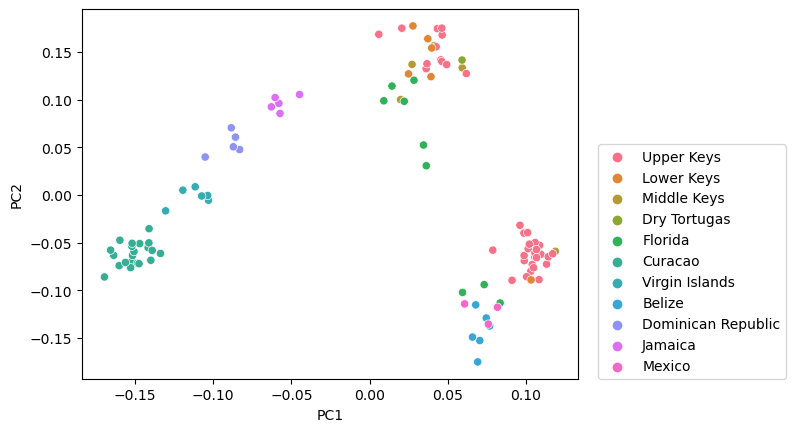

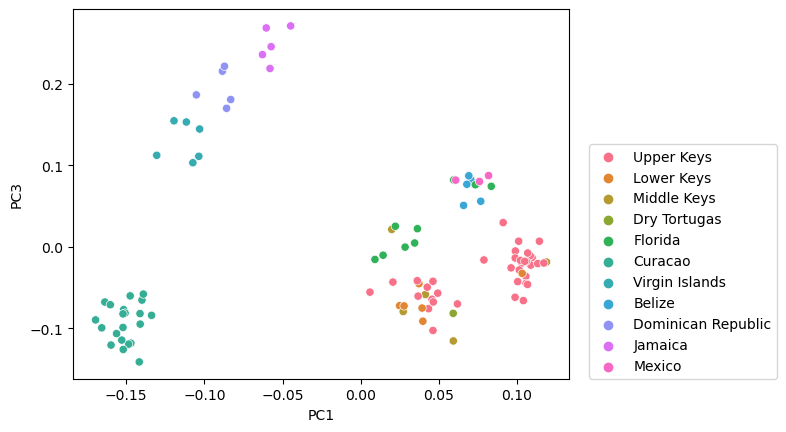

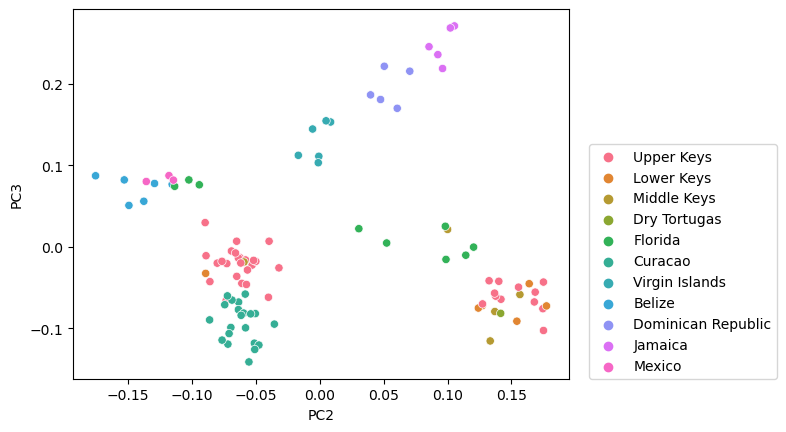

In [103]:
tmp = pd.read_csv("/storage/home/nsl5160/scratch/HWE_pca_pure.eigenvec", sep = "\t")
metadata = pd.read_csv("../filtered_DARPA_metadata_fixed.csv")
metadata["#IID"] = metadata["Novogene_ID"]
tmp = tmp.merge(metadata[["#IID", "Region"]], how = "left", on = "#IID")
sns.scatterplot(data = tmp, x = "PC1", y = "PC2", hue = "Region")
plt.legend(loc=(1.04, 0))
plt.figure()
sns.scatterplot(data = tmp, x = "PC1", y = "PC3", hue = "Region")
plt.legend(loc=(1.04, 0))
plt.figure()
sns.scatterplot(data = tmp, x = "PC2", y = "PC3", hue = "Region")
plt.legend(loc=(1.04, 0))

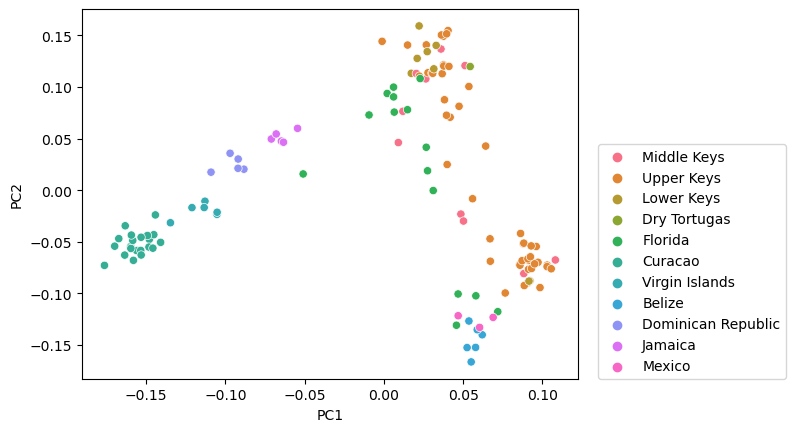

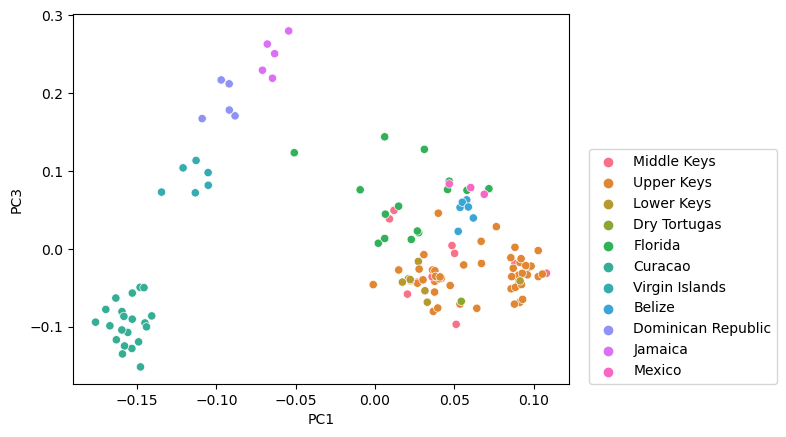

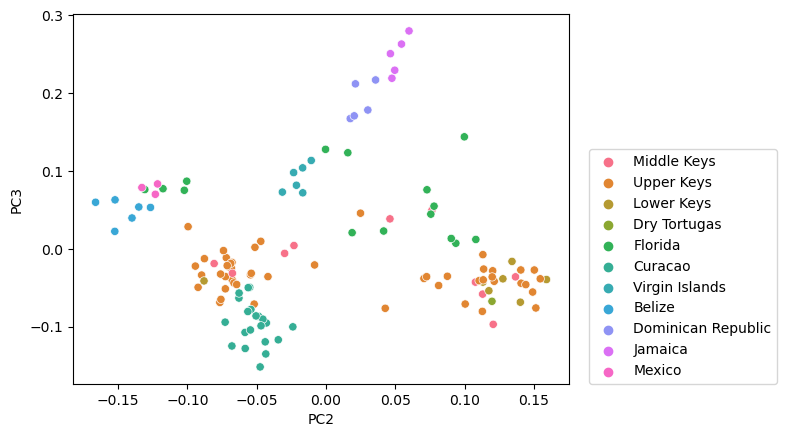

In [95]:
tmp = pd.read_csv("/storage/home/nsl5160/scratch/HWE_pca.eigenvec", sep = "\t")
metadata = pd.read_csv("../filtered_DARPA_metadata_fixed.csv")
metadata["#IID"] = metadata["Novogene_ID"]
tmp = tmp.merge(metadata[["#IID", "Region"]], how = "left", on = "#IID")
sns.scatterplot(data = tmp, x = "PC1", y = "PC2", hue = "Region")
plt.legend(loc=(1.04, 0))
plt.figure()
sns.scatterplot(data = tmp, x = "PC1", y = "PC3", hue = "Region")
plt.legend(loc=(1.04, 0))
plt.figure()
sns.scatterplot(data = tmp, x = "PC2", y = "PC3", hue = "Region")
plt.legend(loc=(1.04, 0))

In [5]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools view -m2 -M2 -v snps -i 'F_MISSING==0' \
    ../calls/apal_imputation_panel_unrelated_illumina_filtered_whatshap.vcf.gz \
    | bcftools annotate --remove "INFO" \
    | bcftools view \
    --samples-file ../pure_florida.txt --targets-file ^../references/repeats.sorted.bed \
    | bcftools +fill-tags -- -t all \
    | bcftools view --min-ac 3:minor -e 'COUNT(GT="AA")=N_SAMPLES || COUNT(GT="RR")=N_SAMPLES' \
    -O v > ~/scratch/HWE_in.vcf

In [ ]:
%%bash
source ~/.bashrc
conda activate pcangsd
../ruth/bin/ruth --evec /storage/home/nsl5160/scratch/HWE_pca_pure.eigenvec \
    --vcf /storage/home/nsl5160/scratch/HWE_in.vcf \
    --field PL \
    --site-only \
    --out /storage/home/nsl5160/scratch/RUTH_HWE.vcf

In [16]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools query -l ~/scratch/HWE_in.vcf | wc -l

103


In [10]:
RUTH = pd.read_csv("~/scratch/RUTH_HWE.vcf", comment = "#", sep = "\t", header = None)

In [12]:
RUTH["logp"] = RUTH[7].str.split(";", expand = True)[13].str.replace("HWE_SLP_I=", "").astype(float)
RUTH["maf"] = RUTH[7].str.split(";", expand = True)[4].str.replace("MAF=", "").astype(float)
RUTH["mac"] = RUTH["maf"] * 206

Here we remove sites significantly out of stratified HWE and alleles that have a minor allele count of >3 (found in more than 1 individual, so unlikely to be error). This is suggested in Linck and Battey 2019 (https://pubmed.ncbi.nlm.nih.gov/30659755/) - MAF >0.05 is an arbitrary filter that makes populations seem more closesly related. We can filter more heavily later if need be:

In [20]:
RUTH = RUTH[(RUTH["logp"] > -5) & (RUTH["logp"] < 5)][RUTH["mac"] > 3].reset_index(drop=True)

/tmp/ipykernel_2422164/3830953010.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  RUTH = RUTH[(RUTH["logp"] > -5) & (RUTH["logp"] < 5)][RUTH["mac"] > 3].reset_index(drop=True)


In [21]:
RUTH = RUTH[[0, 1]]
RUTH.columns = ["CHR", "POS"]
RUTH.set_index("CHR").to_csv("../calls/panel_positions.tsv", sep = "\t", header = None)

In [23]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools view -m2 -M2 -v snps --samples-file ../pure_florida.txt \
    -T ../calls/panel_positions.tsv \
    ../calls/apal_imputation_panel_unrelated_illumina_filtered_whatshap.vcf.gz \
    | bcftools annotate --remove "INFO" \
    | bcftools +fill-tags -- -t all \
    | bcftools view -O z > ../calls/refpanel.vcf.gz
tabix ../calls/refpanel.vcf.gz

In [24]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools view ../calls/refpanel.vcf.gz -H | wc -l

2343144


Now that we have a reliable set of SNPs for the reference panel, we'll use ShapeIT4 to population phase the unrelated dataset. We unfortunately don't have enough data to phase each genetic cluster separately, so we'll phase the whole dataset together. The hope is that this should be a fine approach since we also performed read-backed phasing beforehand:

In [25]:
task = "shapeit4_phase"
mem = "500"
cpus = "40"
infile = "refpanel.vcf.gz"
group = "refpanel"
outpath = "../shapeit_phase"
subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
     cpus + " ../" + task + ".sh " + 
     infile + " " + outpath + " " + group], shell=True)

Submitted batch job 9004837


CompletedProcess(args=['sbatch --mem=500g --ntasks=40 ../shapeit4_phase.sh refpanel.vcf.gz ../shapeit_phase refpanel'], returncode=0)

In [26]:
!ls ../shapeit_phase/refpanel*.bcf | cut -d"/" -f3 | rev | cut -d"." -f2 | rev > ../files.txt

In [27]:
ordered = pd.read_csv("../references/apal_and_sym.bed", header = None, names = ["CHR", "START", "END"], sep = "\t")
files = pd.read_csv("../files.txt", header = None, names = ["CHR"])
ordered = ordered[ordered["CHR"].isin(files["CHR"])].reset_index(drop=True)

In [28]:
ordered["CHR"] = "../shapeit_phase/refpanel.scaffold." + ordered["CHR"] + ".bcf"

In [29]:
ordered[["CHR"]].set_index("CHR").to_csv("../files.txt", header = None)

In [31]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools concat -f ../files.txt -o ../shapeit_phase/all.phased.bcf --threads 8
bcftools index -f ../shapeit_phase/all.phased.bcf

Checking the headers and starting positions of 386 files
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_1.bcf	0.118725 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_2.bcf	0.138025 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_3.bcf	0.002241 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_4.bcf	0.194848 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_5.bcf	0.122623 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_6.bcf	0.129087 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_7.bcf	0.003751 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_8.bcf	0.002648 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_9.bcf	0.001046 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_10.bcf	0.149846 seconds
Concatenating ../shapeit_phase/refpanel.sc

Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_94.bcf	0.000493 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_95.bcf	0.000486 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_96.bcf	0.000587 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_97.bcf	0.001003 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_98.bcf	0.001705 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_100.bcf	0.000662 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_101.bcf	0.000590 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_102.bcf	0.000706 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_103.bcf	0.000972 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_104.bcf	0.000669 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_105.bcf	0.000551 s

Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_187.bcf	0.000530 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_188.bcf	0.001103 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_189.bcf	0.002935 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_190.bcf	0.000682 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_191.bcf	0.000854 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_192.bcf	0.000629 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_193.bcf	0.000562 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_194.bcf	0.000805 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_195.bcf	0.000975 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_196.bcf	0.001893 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_hic_scaffold_197.bcf	0.002

Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_387_HRSCAF_700.bcf	0.000832 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_247_HRSCAF_411.bcf	0.000570 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_66_HRSCAF_114.bcf	0.000571 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_133_HRSCAF_241.bcf	0.000530 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_418_HRSCAF_789.bcf	0.000607 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_415_HRSCAF_784.bcf	0.000597 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_344_HRSCAF_598.bcf	0.000701 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_73_HRSCAF_129.bcf	0.000773 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_391_HRSCAF_715.bcf	0.002005 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_118_HRSCAF_214.bcf	0.001024 seconds
Concatenating ../shape

Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_231_HRSCAF_389.bcf	0.000673 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_113_HRSCAF_207.bcf	0.000545 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_419_HRSCAF_792.bcf	0.000729 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_52_HRSCAF_88.bcf	0.000647 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_377_HRSCAF_675.bcf	0.000708 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_268_HRSCAF_440.bcf	0.000635 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_60_HRSCAF_105.bcf	0.002179 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_440_HRSCAF_826.bcf	0.000499 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_402_HRSCAF_756.bcf	0.000772 seconds
Concatenating ../shapeit_phase/refpanel.scaffold.Apal_Sc0a5M3_37_HRSCAF_65.bcf	0.000773 seconds
Concatenating ../shapeit_

In [32]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools view ../shapeit_phase/all.phased.bcf | bcftools +fill-tags -- -t all \
    | bcftools view -O b > ../calls/all.phased.tagged.bcf

In [33]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools view ../calls/all.phased.tagged.bcf | grep -v "^#" | wc -l

2343144


This is our final reference panel dataset of 2.3M markers ^

In [23]:
for i in metadata["Baums_db_id"].tolist():
    task = "longphase_modcall"
    mem = "128"
    cpus = "20"
    inpath = '/storage/home/nsl5160/scratch/darpa/mapped'
    outpath = '../calls'
    prefix = str(i)
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         inpath + " " + outpath + " " + prefix], shell=True)

Submitted batch job 5178029
Submitted batch job 5178030
Submitted batch job 5178031
Submitted batch job 5178032
Submitted batch job 5178033
Submitted batch job 5178034


In [4]:
alphabet = [chr(x) for x in range(97, 123)]
chunks = [letter1+letter2 for letter1 in alphabet for letter2 in alphabet][0:78]

In [30]:
for i in chunks:
    task = "bcftools_call_var_ccs"
    mem = "32"
    cpus = "4"
    chunk = i
    bampath = '../apal_imputation_bam_hifi.list'
    outpath = "/storage/group/ibb3/default/darpa/calls/"
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         outpath + " " + bampath + " " + chunk], shell=True)

Submitted batch job 5178276
Submitted batch job 5178277
Submitted batch job 5178278
Submitted batch job 5178279
Submitted batch job 5178280
Submitted batch job 5178281
Submitted batch job 5178282
Submitted batch job 5178283
Submitted batch job 5178284
Submitted batch job 5178285
Submitted batch job 5178286
Submitted batch job 5178287
Submitted batch job 5178288
Submitted batch job 5178289
Submitted batch job 5178290
Submitted batch job 5178291
Submitted batch job 5178292
Submitted batch job 5178293
Submitted batch job 5178294
Submitted batch job 5178295
Submitted batch job 5178296
Submitted batch job 5178297
Submitted batch job 5178298
Submitted batch job 5178299
Submitted batch job 5178300
Submitted batch job 5178301
Submitted batch job 5178302
Submitted batch job 5178303
Submitted batch job 5178304
Submitted batch job 5178305
Submitted batch job 5178306
Submitted batch job 5178307
Submitted batch job 5178308
Submitted batch job 5178309
Submitted batch job 5178310
Submitted batch job 

In [31]:
%%bash
source ~/.bashrc
conda activate ipyrad
bcftools concat ../calls/apal_imputation_panel_hifi_part_??.vcf \
    -O z > ../calls/apal_imputation_panel_hifi.vcf.gz

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [37]:
%%bash
for i in 20148 20151 20153 20154 20155 20156; do
    echo -e "/storage/home/nsl5160/scratch/darpa/mapped/${i}.bam\t${i}" >> ../hifi_header.txt
done

In [40]:
%%bash
source ~/.bashrc
conda activate ipyrad
bcftools reheader --threads 8 --samples ../hifi_header.txt \
    ../calls/apal_imputation_panel_hifi.vcf.gz \
    > ../calls/apal_imputation_panel_hifi_reheader.vcf.gz

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [45]:
%%bash
source ~/.bashrc
conda activate ipyrad
for i in 20148 20151 20153 20154 20155 20156; do
    vcftools --gzvcf ../calls/apal_imputation_panel_hifi_reheader.vcf.gz \
        --minGQ 20 --minQ 20 --recode-INFO-all \
        --indv ${i} \
        --recode --out ../calls/${i}
done

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ../calls/apal_imputation_panel_hifi_reheader.vcf.gz
	--recode-INFO-all
	--minGQ 20
	--minQ 20
	--out ../calls/20148
	--recode
	--indv 20148

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 1 out of 6 Individuals
Outputting VCF file...
After filtering, kept 4531120 out of a possible 4784593 Sites
Run Time = 61.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ../calls/apal_imputation_panel_hifi_reheader.vcf.gz
	--recode-INFO-all
	--minGQ 20
	--minQ 20
	--out ../calls/20151
	--recode
	--indv 20151

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 1 out of 6 Individuals
Outputting VCF file...
After filtering, kept 4531120 out of a possible 4784593 Sites
Run Time = 61.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:

In [46]:
for i in metadata["Baums_db_id"].tolist():
    task = "longphase_phase"
    mem = "128"
    cpus = "20"
    bampath = '/storage/home/nsl5160/scratch/darpa/mapped'
    inpath = '../calls'
    prefix = str(i)
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         bampath + " " + inpath + " " + prefix], shell=True)

Submitted batch job 5182946
Submitted batch job 5182947
Submitted batch job 5182948
Submitted batch job 5182949
Submitted batch job 5182950
Submitted batch job 5182951


In [47]:
%%bash
source ~/.bashrc
conda activate ipyrad
for i in 20148 20151 20153 20154 20155 20156; do
    bgzip ../calls/${i}_phased.vcf
    tabix ../calls/${i}_phased.vcf.gz
done

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


Lastly, we need to call CNVs so they can be removed from the panel. Could mess up imputation and phasing if we don't remove them:

In [55]:
%%bash
cut -f1-3 \
    /storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.0_200415.repeats.bed \
    > ../apal_rust_compatible_repeats.bed
sed -i "s/^/Apal_/g" ../apal_rust_compatible_repeats.bed
grep "^sym" ../references/apal_and_sym.bed >> ../apal_rust_compatible_repeats.bed

In [5]:
for i in metadata["Baums_db_id"].tolist():
    task = "hificnv"
    mem = "128"
    cpus = "20"
    bampath = '/storage/home/nsl5160/scratch/darpa/mapped'
    outpath = '../calls' 
    prefix = str(i) 
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         bampath + " " + outpath + " " + prefix], shell=True)

Submitted batch job 5218769
Submitted batch job 5218770
Submitted batch job 5218771
Submitted batch job 5218772
Submitted batch job 5218773
Submitted batch job 5218774


In [6]:
%%bash
source ~/.bashrc
conda activate ipyrad
cd ../references/
bioawk -c fastx '{print $name"\t0\t"length($seq)}' apal2_and_sym.fa > apal2_and_sym.bed

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [7]:
%%bash
grep "^sym" ../references/apal2_and_sym.bed >> ../apal2_exclude.bed

In [8]:
for i in metadata["Baums_db_id"].tolist():
    task = "hificnv_2"
    mem = "128"
    cpus = "20"
    bampath = '/storage/home/nsl5160/scratch/darpa/mapped2'
    outpath = '../calls/test' 
    prefix = str(i)
    subprocess.run(["sbatch --mem=" + mem + "g --ntasks=" + 
         cpus + " ../" + task + ".sh " + 
         bampath + " " + outpath + " " + prefix], shell=True)

Submitted batch job 5218897
Submitted batch job 5218898
Submitted batch job 5218899
Submitted batch job 5218900
Submitted batch job 5218901
Submitted batch job 5218902


In [90]:
for i in metadata["Baums_db_id"].tolist():
    path = glob.glob("../calls/" + str(i) + "_hificnv.*.vcf.gz")
    vcf = pd.read_csv(path[0], 
            compression = "gzip", comment = "#", header = None, sep = "\t")
    vcf = vcf[vcf[5] > 20].reset_index(drop=True)
    vcf["SVLEN"] = vcf[7].str.split(";", n = 4, expand = True)[3].str.replace("SVLEN=", "").astype(int)
    vcf["END"] = vcf[1] + vcf["SVLEN"]
    vcf = vcf[[0, 1, "END"]]
    vcf[1] = vcf[1] - 1
    vcf["END"] = vcf["END"] - 1
    vcf.set_index(0).to_csv("../calls/" + str(i) + "_hificnv.bed", sep = "\t", header = None)

In [111]:
for i in metadata["Baums_db_id"].tolist():
    subprocess.run(["cat ../calls/" + str(i) 
          + "_hificnv.bed >> ../references/repeats_and_cnv.bed"], shell=True)
for i in ["repeats"]:
    subprocess.run(["cut -f1-3 ../references/" + str(i) 
          + ".bed >> ../references/repeats_and_cnv.bed"], shell=True)
subprocess.run(["sort -k1,1 -k2,2n ../references/repeats_and_cnv.bed > ../references/repeats_and_cnv_sorted.bed"], shell=True)

CompletedProcess(args=['sort -k1,1 -k2,2n ../references/repeats_and_cnv.bed > ../references/repeats_and_cnv_sorted.bed'], returncode=0)

In [113]:
%%bash
source ~/.bashrc
conda activate ipyrad
bedtools merge -i ../references/repeats_and_cnv_sorted.bed \
    > ../references/repeats_and_cnv_sorted_merged.bed

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
